# Explaining TabPFN

TabPFN is a foundation model for tabular data, which uses in-context learning to do solve classification and regression tasks.
TabPFN outperforms traditional models like Random Forest, Gradient Boosting for small datasets and raises the state-of-the-art for tabular data!
Recently, a major update was released, which includes a new architecture and an updated API.

For more information about TabPFN, check the [github repository](https://github.com/PriorLabs/TabPFN) and the associated papers ([TabPFN](https://openreview.net/forum?id=eu9fVjVasr4), [TabPFNv2](https://www.nature.com/articles/s41586-024-08328-6)).

In this tutorial, we see how we can **use shapiq to explain the predictions of TabPFNv2**. 
We will use the California housing dataset and train a TabPFN model to predict the house prices.
Many explanation methods show that models tend to learn interactions between the latitude and longitude features, containing information about the exact location of a house.
We want to see if TabPFN also learns the interactions between latitude and longitude.

First, lets import the libraries (tabpfn and shapiq) and check their versions.
Note that this tutorial uses the latest version of TabPFN (> 2.0.0) and will not necessarily work with older versions.

In [1]:
from importlib.metadata import version

import shapiq
import tabpfn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("shapiq version: ", shapiq.__version__)
print("tabpfn version: ", version("tabpfn"))
print("Device: ", device)

shapiq version:  1.1.1.dev
tabpfn version:  2.0.1
Device:  cpu


## Get the California Housing Data
Now let's load the California housing dataset and inspect the data.

In [2]:
x_data, y_data = shapiq.datasets.load_california_housing()
feature_names = x_data.columns

# copy the data to make sure we don't modify the original data
dataset = x_data.copy()
dataset["HousePrice"] = y_data
display(dataset.head())
display(dataset["HousePrice"].describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousePrice
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: HousePrice, dtype: float64

Now we have loaded the data.
**HousePrice** is the target variable we want to predict.
The target ranges from 0.15 to 5.0.

In order to use TabPFN, we need to split the data into a training and testing set.
Note, that TabPFN works best for **small sized datasets** (less than 10k samples).
On CPU, we can only use a very small number of training data points to fit the model. If you have a GPU, feel free to increase the number of samples.

In [3]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_data.values, y_data.values, train_size=500, random_state=42
)
print("Train data shape: ", x_train.shape, y_train.shape)
print("Test data shape: ", x_test.shape, y_test.shape)

Train data shape:  (500, 8) (500,)
Test data shape:  (20140, 8) (20140,)


## Fit TabPFN
Now that we have the data, we can fit TabPFN to the training data and make it ready for predictions. 

**Note** that TabPFN at the end of the day is still quite a big transformer model, which needs a GPU to run efficiently.
If you are on GPU, feel free to increase the number of samples in the training or testing sets in the following:

In [4]:
model = tabpfn.TabPFNRegressor(n_jobs=7, device=device)
model.fit(x_train, y_train)

TabPFNRegressor(device=device(type='cpu'), n_jobs=7)

When we have the "trained" model, we can use it to predict the house prices.
These predictions are very competitive with the state-of-the-art models.

## Evaluate TabPFN

In [5]:
# we downsample the test data for more efficient inference
x_test, y_test = x_test[:2000], y_test[:2000]
predictions = model.predict(x_test)

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("MSE: ", mse, "R2: ", r2)

average_prediction = np.mean(predictions)
print("Average prediction: ", average_prediction)

MSE:  0.27149947144257525 R2:  0.796390135236755
Average prediction:  2.0852828


In [7]:
# we will reset the model to less training data because we are on CPU
if device == torch.device("cpu"):
    print("Resetting the model to less training data:", x_train.shape[0])
    x_train, y_train = x_train[:50], y_train[:50]
    model.fit(x_train, y_train)

Resetting the model to less training data: 500


## Explain TabPFN with shapiq
Now that we see how TabPFN performs, we can use shapiq to explain the predictions.
First, we will use the KernelSHAP method to explain the predictions.

In [8]:
x_explain = x_data.values[1000]
y_explain = y_data.values[1000]

prediction = model.predict(x_explain.reshape(1, -1))[0]
print("Prediction: ", prediction)
print("True value: ", y_explain)
print("Average prediction: ", average_prediction)

Prediction:  1.8186865
True value:  1.844
Average prediction:  2.0852828


### Traditional Explanation with Baseline Imputation
The traditional way to explain any black-box model trained on tabular data is by using imputation strategies for feature removal (excellent [paper by Covert et al.](https://jmlr.csail.mit.edu/papers/volume22/20-1316/20-1316.pdf)).
During explanations, the model is queried multiple times with different subsets of features removed.
Removed features are imputed using different strategies, such as the baseline imputation.
Baseline imputation replaces the removed features with the mean/mode of the training data.

We can natively use the ``shapiq.Explainer`` (specifically ``shapiq.TabularExplainer``) to explain the TabPFN model:

Evaluating game:   0%|          | 0/256 [00:00<?, ? coalition/s]

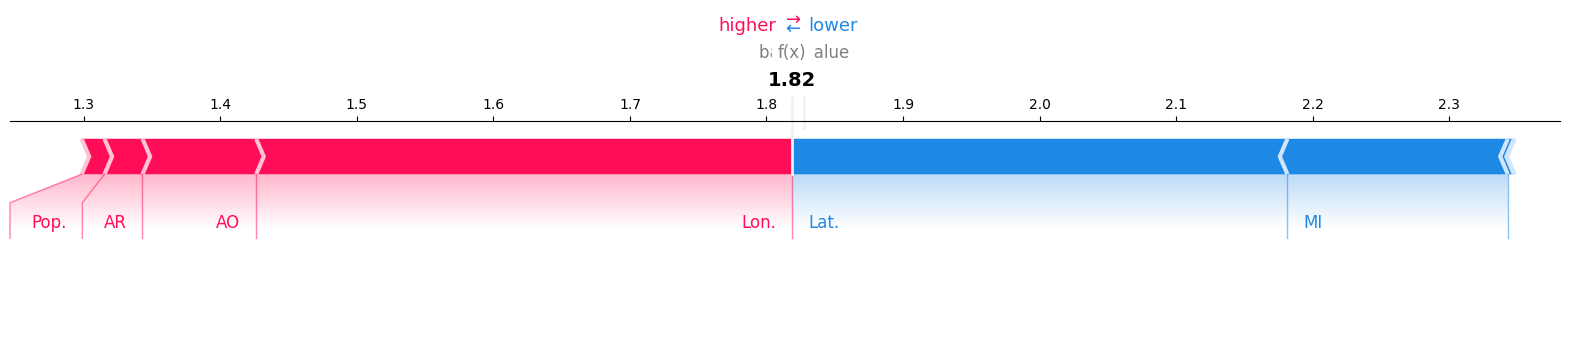

In [9]:
explainer = shapiq.Explainer(model, data=x_test[:50], index="SV", max_order=1, imputer="baseline")
explainer._imputer.verbose = True  # see the explanation progress

shapley_values = explainer.explain(x_explain)
shapley_values.plot_force(feature_names=feature_names)

### Explaining TabPFN with Remove-and-"Retrain"

Since TabPFN is a foundation model, it uses in-context learning to solve the classification and regression tasks.
This means that "retraining" the model is quite inexpensive, because we only need to provide the new data points with whatever features we want to remove.
A recent paper by [Rundel et al.](https://arxiv.org/pdf/2403.10923) shows that this strategy is very effective for explaining models like TabPFN.

Because of ``shapiq``'s notion of cooperative games, we can easily implement the remove-and-"retrain" strategy for TabPFN as game.
The game takes the model, the training data, the explanation data, and the average prediction as input.
The value function of the game performs the remove-and-"retrain" strategy for TabPFN and returns the predictions for the coalitions.

In [10]:
class TabPFNGame(shapiq.Game):
    """The TabPFN Game class implementation a remove-and-"retrain" strategy to explain the predictions of TabPFN.

    Args:
        model: The TabPFN model.
        x_train: The training data.
        y_train: The training labels.
        x_explain: The data point to explain.
        average_prediction: The average prediction of the model.
    """

    def __init__(self, model, x_train, y_train, x_explain, average_prediction):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_explain = x_explain
        self.average_prediction = average_prediction

        print("Initializing TabPFN Game")
        print("Train data shape: ", x_train.shape, y_train.shape)
        print("Explain data shape: ", x_explain.shape)

        super().__init__(n_players=x_train.shape[1], normalization_value=self.average_prediction)

    def value_function(self, coalitions: np.ndarray) -> np.ndarray:
        """The value function performs the remove-and-"retrain" strategy for TabPFN."""
        output = np.zeros(len(coalitions), dtype=float)
        for i, coalition in enumerate(coalitions):
            if sum(coalition) == 0:
                output[i] = self.average_prediction
                continue
            x_train_coal = self.x_train[:, coalition]
            x_explain_coal = self.x_explain[coalition].reshape(1, -1)
            self.model.fit(x_train_coal, self.y_train)
            pred = float(self.model.predict(x_explain_coal)[0])
            output[i] = pred
        return output

With this game implementation we can now use helper functions from ``shapiq.Game`` like ``precompute`` to precompute the values of the game to speed up the explanation process.
For reproducibility, this notebook loads a precomputed game from the file ``tabpfn_values.npz`` if it exists.

In [11]:
import os

if not os.path.exists("tabpfn_values.npz"):
    tabpfn_game = TabPFNGame(model, x_train, y_train, x_explain, average_prediction)
    tabpfn_game.verbose = True  # see the pre-computation progress
    tabpfn_game.precompute()
    tabpfn_game.save_values("tabpfn_values.npz")

tabpfn_game = shapiq.Game(path_to_values="tabpfn_values.npz", normalize=False)

Now that we have evaluated all $2^d$ coalitions, we can use ``shapiq.ExactComputer`` to compute any kind of game-theoretic explanation.

With a precomputed ``shapiq.Game``, we can quickly check different explanation methods like Shapley values or Faithful Shapley Interaction values.
We can also query the game for values from specific coalitions like what TabPFN predicts when we provide all features or only a subset of features: 

In [12]:
print("No features: ", tabpfn_game[()])
print("All features: ", tabpfn_game[tuple(range(tabpfn_game.n_players))])
print("Latitude and Longitude: ", tabpfn_game[(6, 7)])  # lat. and lon. are at index 6 and 7

No features:  2.0861093997955322
All features:  1.8420544862747192
Latitude and Longitude:  1.6669323444366455


Only providing the latitude and longitude features results in a prediction of 1.66, which is less than the average prediction of around 2.0 and the prediction with all features, which would be 1.84. 
This suggests that the latitude and longitude may reduce the house price.
Let's compute some explanation values for the TabPFN model with ``shapiq.ExactComputer`` and check this out:

In [14]:
exact_computer = shapiq.ExactComputer(n_players=tabpfn_game.n_players, game=tabpfn_game)
sv = exact_computer(index="SV", order=1)  # compute the Shapley values
fsii = exact_computer(index="FSII", order=2)  # compute Faithful Shapley Interaction values

{(): 2.0861093997955322,
 (0,): -0.16847709885665363,
 (1,): 0.030854925797099225,
 (2,): -0.04534098236333772,
 (3,): 0.06734204618703749,
 (4,): 0.010694948690278039,
 (5,): 0.023461689409755293,
 (6,): -0.09278867258912055,
 (7,): -0.06980176979587177}

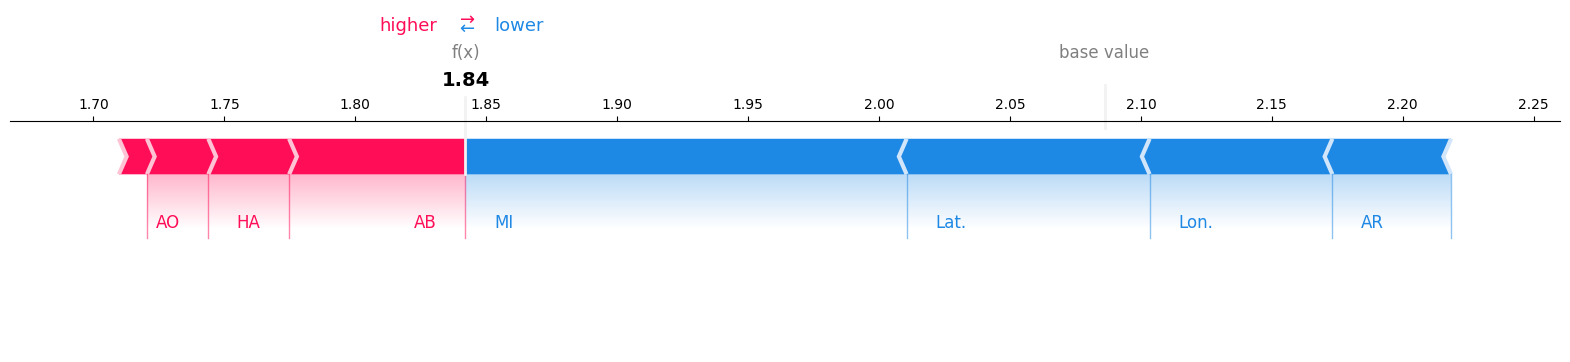

In [15]:
display(sv.dict_values)
sv.plot_force(feature_names=feature_names)

From the Shapley values, we can see that both latitude and longitude have a negative impact on the house price.
When we compute second order Shapley interactions (``index=FSII``, ``order=2``) we can see that the interaction between latitude and longitude together actually has a very negative impact on the house price.

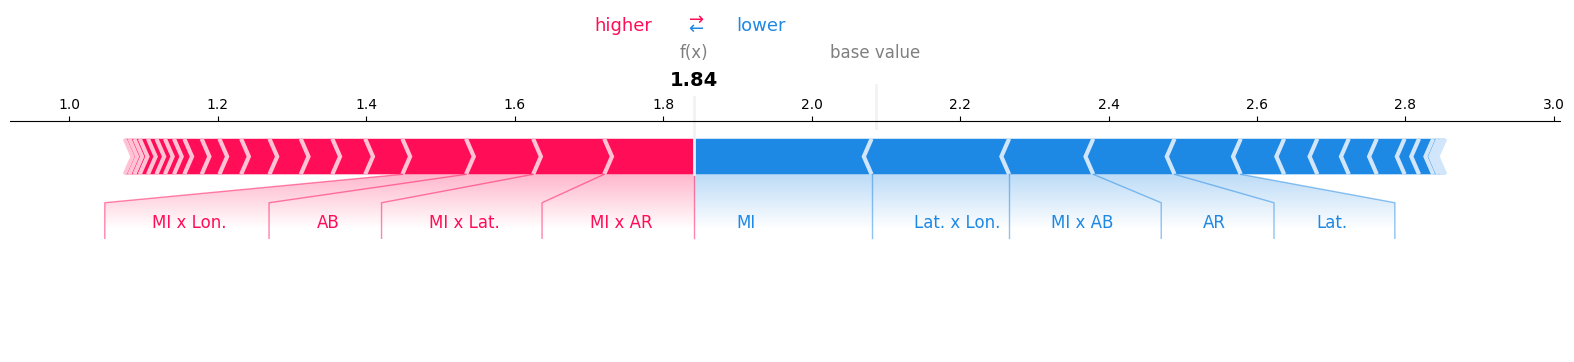

In [16]:
fsii.plot_force(feature_names=feature_names)

### Explain TabPFN with Approximation Methods for Shapley Values and Interactions
When we have a large number of features, the exact computation of Shapley values and interactions can be computationally expensive.
For this reason, we can use approximation methods like KernelSHAP, KernelSHAP-IQ or Faithful Regression to approximate the Shapley values and interactions with a computational budget.

To illustrate the approximation methods, we use the same TabPFN game (which has only 8 features) but reduce the computational budget to 50 model evaluations.
First, we approximate the Shapley values with KernelSHAP:

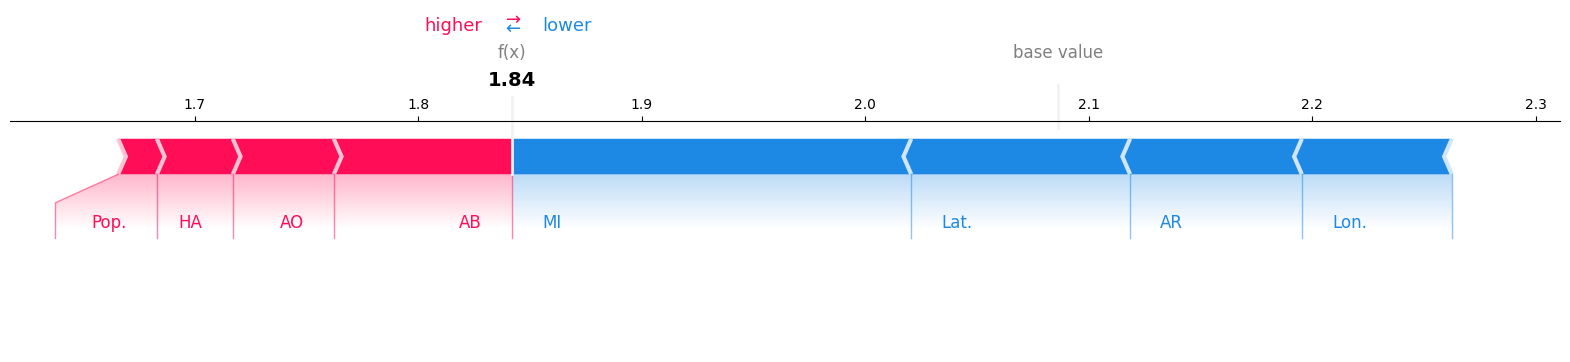

In [17]:
approximator = shapiq.KernelSHAP(n=tabpfn_game.n_players, random_state=42)
sv = approximator.approximate(budget=50, game=tabpfn_game)
sv.plot_force(feature_names=feature_names)

C:\1_Workspaces\1_Phd_Projects\shapiq\shapiq\approximator\regression\_base.py:342: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.

  warnings.warn(


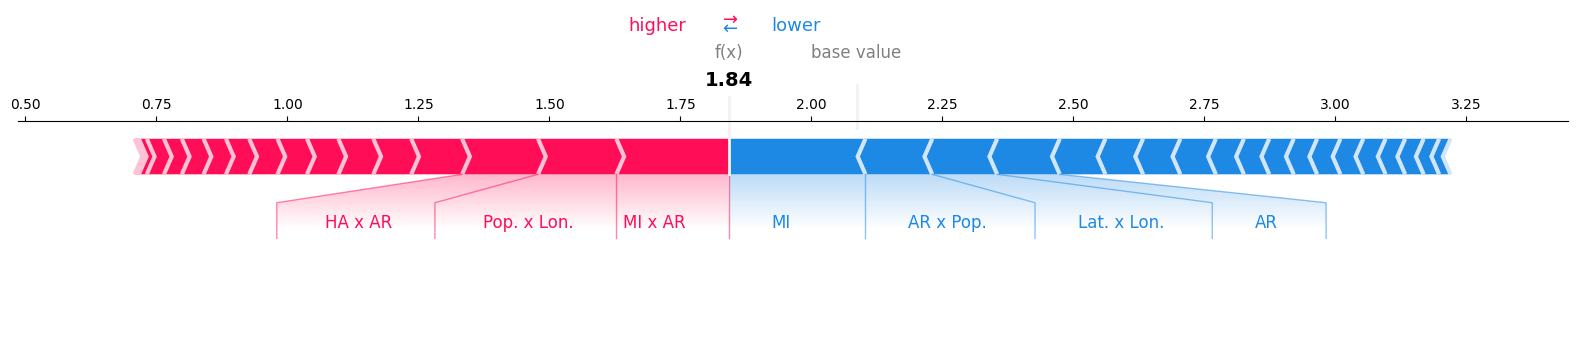

In [18]:
approximator = shapiq.RegressionFSII(n=tabpfn_game.n_players, random_state=42, max_order=2)
fsii = approximator.approximate(budget=50, game=tabpfn_game)
fsii.plot_force(feature_names=feature_names)